Nombre: Alberto José Mendoza Peñaloza

# Parte 2

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Importación de Librerías

In [114]:
# graficas y estadisticas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Despliegue
import joblib
import logging

In [122]:
data = pd.read_csv('/content/drive/MyDrive/TESTS/RAPPI/orders_challengue_sep2023_PE_CO.csv')

In [48]:
data.head()

,ORDER_ID,CREATED_AT,TO_USER_DISTANCE,TOTAL_EARNINGS,DISTANCE_TO_STORE,TIP,COUNTRY,CITY,SATURATION,TAKEN
0,2160622823,2023-09-02T19:24:16.793784Z,6.3,8032.39,1.048795,0.0,CO,"""medellin""",0,1
1,2160418716,2023-09-02T00:28:09.358242Z,5.5,14350.00,0.517170,5400.0,CO,"""bogota""",0,0
2,2160741817,2023-09-02T23:21:02.006797Z,1.9,2800.00,0.196478,0.0,CO,"""pereira""",0,1
3,2160708953,2023-09-02T21:28:16.32926Z,5.1,6923.79,0.924649,0.0,CO,"""medellin""",0,0
4,2160556289,2023-09-02T14:52:50.648279Z,3.7,4278.56,0.263326,5000.0,CO,"""bogota""",0,1


# 1. EDA

El objetivo de esta práctica es desarrollar un modelo de clasificación para la variable TAKEN. Se interpreta que la variable TAKEN verifica si un pedido o una orden fue finalizada o no.

En el dataset hay 10 variables, para crear el modelo, de las cuales se hara refinamiento para observar las más importantes.

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488653 entries, 0 to 4488652
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ORDER_ID           int64  
 1   CREATED_AT         object 
 2   TO_USER_DISTANCE   float64
 3   TOTAL_EARNINGS     float64
 4   DISTANCE_TO_STORE  float64
 5   TIP                float64
 6   COUNTRY            object 
 7   CITY               object 
 8   SATURATION         int64  
 9   TAKEN              int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 342.5+ MB


## 1.1 Dimensiones del dataset

In [50]:
data.shape

(4488653, 10)

Vemos que tiene 4 millones de registros lo cual es bastante información y puede servir para hacer un buen modelo.

## 1.2 Reporte de Nulos

In [51]:
data.isnull().sum()

,0
ORDER_ID,0
CREATED_AT,0
TO_USER_DISTANCE,0
TOTAL_EARNINGS,0
DISTANCE_TO_STORE,0
TIP,0
COUNTRY,0
CITY,0
SATURATION,0
TAKEN,0


Observamos que el dataset no cuenta con registros nulos.

## 1.3 Reporte de Duplicados

In [52]:
data["ORDER_ID"].duplicated().sum()

0

Observamos que cada orden es única y el dataset no tiene duplicados.

## 1.4 Histograma para Variables Numéricas

In [53]:
numeric_columns = []
categoric_columns = []
for c in data:
  if np.issubdtype(data[c].dtype, np.number):
    numeric_columns.append(c)
  else:
    categoric_columns.append(c)

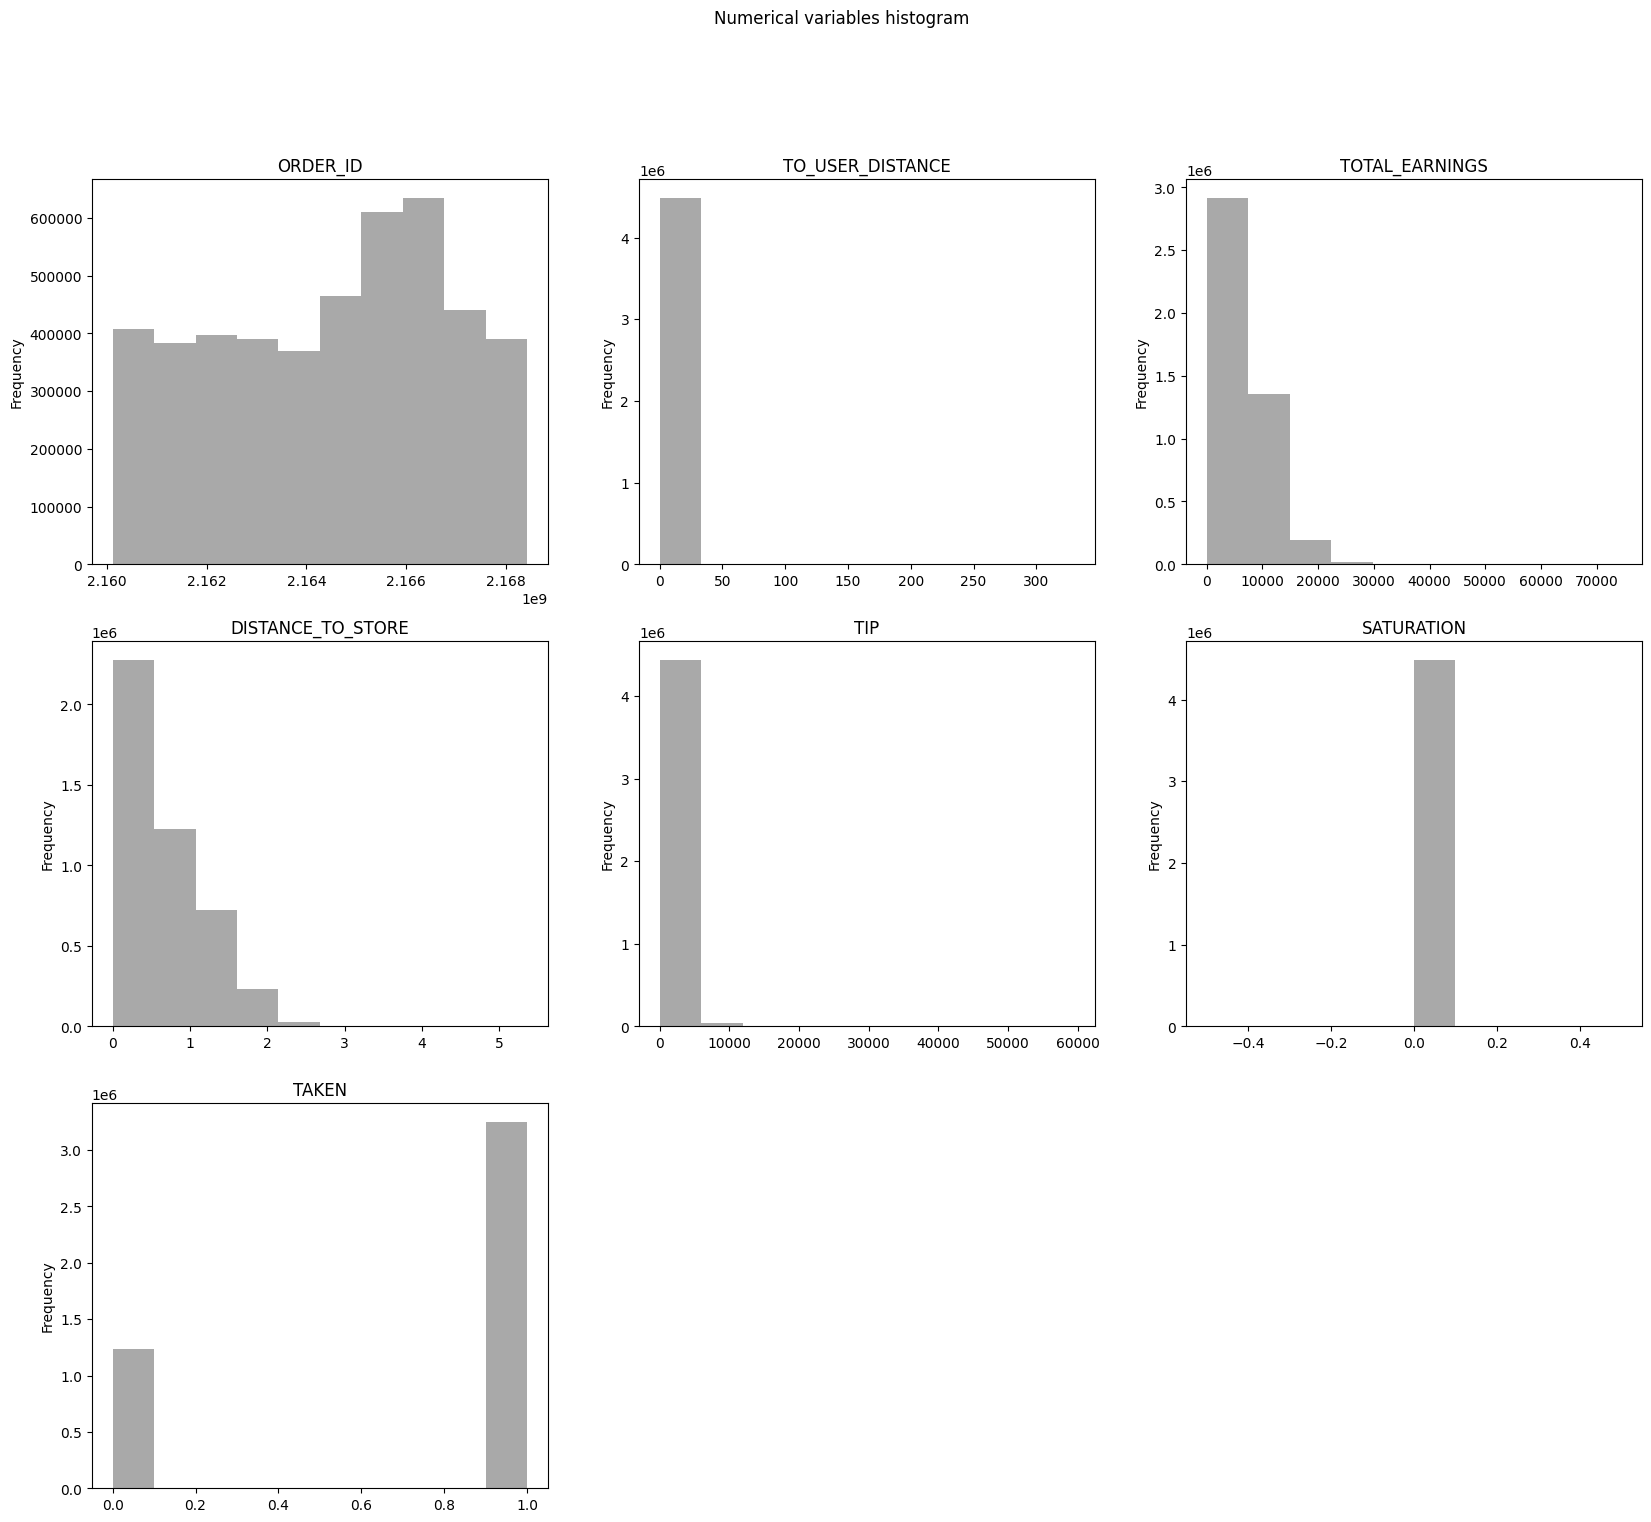

In [54]:
plt.figure(figsize=(20,17))
plt.suptitle('Numerical variables histogram')
for i in range(len(numeric_columns)):
  plt.subplot((int(len(numeric_columns)/3))+1,3,i+1)
  plt.title(numeric_columns[i])
  data[numeric_columns[i]].plot.hist(color='darkgrey')
plt.show()

In [55]:
data["TIP"].value_counts()

,count
TIP,
0.0,2345465
1000.0,196466
2000.0,167955
1600.0,108240
1.0,86061
...,...
292.0,1
10038.0,1
21500.0,1


- ORDER_ID es un identificador que no aporta información relevante al modelo por lo tanto se puede eliminar.

- Observamos que la variable SATURATION es constante y su valor es 0 por lo cual no aporta información al modelo.

- Observamos que la varible TIP tiene muchos 0, pero realmente se ve que hace sentido en negocio dado que no todas las personas dan TIPS, por lo que se deja igual.

-  Se observa un claro desbalance en la variable Objetivo.

Para lidiar con el desbalance de la variable objetivo se decide reducir la cantidad de elementos de la clase 1. Esto dado que la cantidad de datos resultante son dos millones, lo cual es suficiente para un buen algoritmo de clasificación por lo general.

In [56]:
class_0 = data[data["TAKEN"]==0]
class_0 = class_0.sample(len(class_0))
class_1 = data[data["TAKEN"]==1]
class_1 = class_1.sample(len(class_0))

data = pd.concat([class_0, class_1])

## 1.5 Observar valores de Variables Categóricas

In [57]:
data["CITY"].value_counts()

,count
CITY,
"""bogota""",949839
"""lima""",457862
"""medellin""",412457
"""cali""",204641
"""barranquilla""",190762
"""cartagena""",37744
"""bucaramanga""",36253
"""pereira""",25483
"""manizales""",16628


Se define dejar las 5 primeras ciudades y luego desarrollar la categoría OTHER para las menores.

In [58]:
data["COUNTRY"].value_counts()

,count
COUNTRY,
CO,1972217
PE,501387


## 1.6 Estadísticas descriptivas

In [59]:
data.describe()

,ORDER_ID,TO_USER_DISTANCE,TOTAL_EARNINGS,DISTANCE_TO_STORE,TIP,SATURATION,TAKEN
count,2.473604e+06,2.473604e+06,2.473604e+06,2.473604e+06,2.473604e+06,2473604.0,2473604.0
mean,2.164411e+09,3.788818e+00,6.056582e+03,6.266559e-01,1.062290e+03,0.0,0.5
std,2.336046e+06,2.301205e+00,4.630517e+03,5.177047e-01,1.658235e+03,0.0,0.5
min,2.160110e+09,1.000000e-01,2.500000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,2.162414e+09,2.000000e+00,2.800000e+03,1.909060e-01,0.000000e+00,0.0,0.0
50%,2.164699e+09,3.400000e+00,5.800000e+03,4.976788e-01,0.000000e+00,0.0,0.5
75%,2.166368e+09,5.200000e+00,8.650000e+03,9.595148e-01,2.000000e+03,0.0,1.0
max,2.168433e+09,3.010000e+01,7.340000e+04,5.356428e+00,5.599000e+04,0.0,1.0


## 1.7 Boxplot variables numéricas

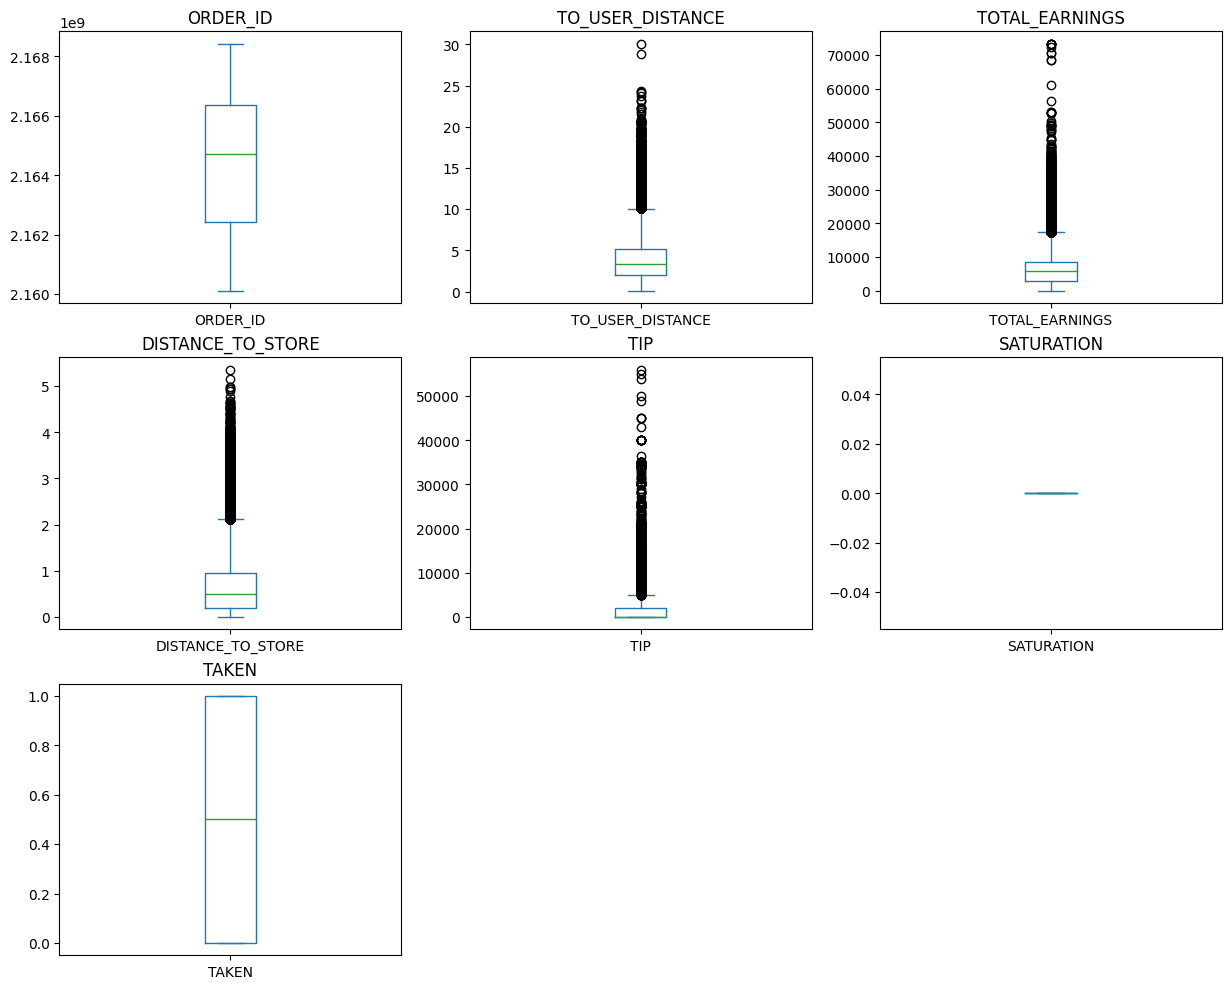

In [60]:
plt.figure(figsize=(15,12))
for i in range(len(numeric_columns)):
  plt.subplot(3,3,i+1)
  plt.title(numeric_columns[i])
  data[numeric_columns[i]].plot.box()
plt.show()

## 1.8 Matriz de Correlación

<Axes: >

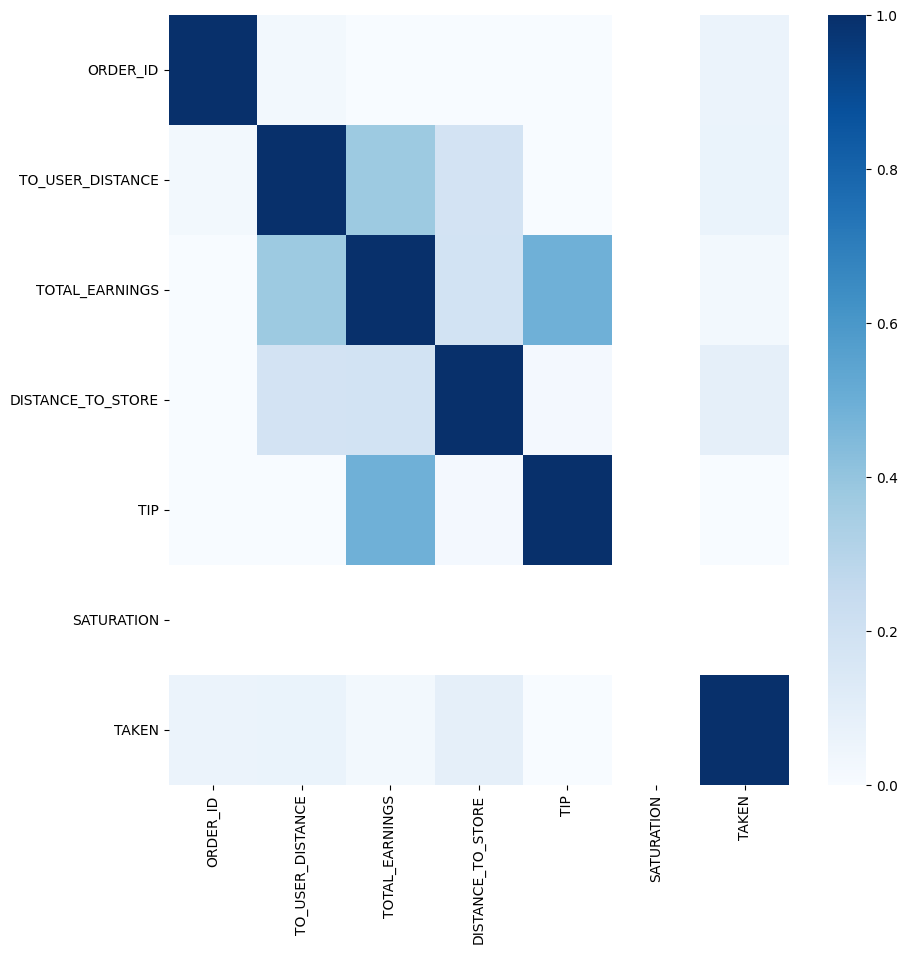

In [61]:
plt.figure(figsize=(10, 10))
sns.heatmap(data[numeric_columns].corr(), cmap="Blues", vmin=0, vmax=1)

# 2. Ingeniería de Variables

## 2.1 División TRAIN-TEST

In [62]:
data['CREATED_AT'] = pd.to_datetime(data['CREATED_AT'], errors='coerce')

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['TAKEN'],axis=1), data['TAKEN'], test_size=0.2, random_state=77)

## 2.2 Eliminar variables irrelevantes

In [64]:
#X_train = X_train.drop(['ORDER_ID', 'SATURATION'], axis=1)

## 2.3 Otros Cambios

- Extraer la hora del dia y el dia de la semana de la fecha
- Tomar 5 principales ciudades y las otras convertirlas en OTHER


# 3. Entrenamiento

## 3.1 Pipeline

In [150]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def convert_categorical(self, df, column, n):
      # Count occurrences of each category
      counts = df[column].value_counts()

      # Get the top n categories by count
      top_categories = counts.index[:n]

      # Convert other categories to a common value
      df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')

      return df

    def transform(self, X, y=None):
        X_copy = X.copy()


        X_copy = X_copy.drop(['ORDER_ID', 'SATURATION'], axis=1)
        X_copy = self.convert_categorical(X_copy, 'CITY', 5)

        # Crear una columna para el día de la semana
        X_copy['dia_semana'] = X_copy['CREATED_AT'].dt.day_name().astype(str)
        # Crear una columna para la hora agrupada en intervalos de 1 hora
        X_copy['hora_grupo'] = X_copy['CREATED_AT'].dt.floor('H').dt.hour.astype(str)

        X_copy = X_copy.drop(['CREATED_AT'], axis=1)

        return X_copy

def create_pipe():
  variable_conversion = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(),  make_column_selector( dtype_include=np.number)),
        ("cat", OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ]
  )
  pipe = Pipeline([
    ('custom_proccesing', CustomTransformer()),
    ('column_transformer',variable_conversion),
    #('classifier', tree.DecisionTreeClassifier())
  ])
  return pipe

In [151]:
pipeline = create_pipe()

In [152]:
%%time
#grid_search.fit(X_train,y_train)
X_train_trans = pipeline.fit_transform(X_train)

CPU times: user 7.92 s, sys: 1.12 s, total: 9.04 s
Wall time: 9.19 s


In [95]:
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

## 3.2 Entrenamiento

In [69]:
model = tree.DecisionTreeClassifier()

In [71]:
%%time
model.fit(X_train_trans,y_train)

CPU times: user 21min 32s, sys: 1.54 s, total: 21min 33s
Wall time: 21min 45s


DecisionTreeClassifier()

In [76]:
# Save the trained model
joblib.dump(model, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

## 3.3 Rendimiento Train

In [72]:
y_pred_train = model.predict(X_train_trans)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    989514
           1       1.00      1.00      1.00    989369

    accuracy                           1.00   1978883
   macro avg       1.00      1.00      1.00   1978883
weighted avg       1.00      1.00      1.00   1978883



## 3.4 Rendimiento Test

In [100]:
X_test_trans = pipeline.transform(X_test)

In [101]:
y_pred_test = model.predict(X_test_trans)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64    247288
           1       0.64      0.64      0.64    247433

    accuracy                           0.64    494721
   macro avg       0.64      0.64      0.64    494721
weighted avg       0.64      0.64      0.64    494721



# 4. Abstracción Entrenamiento

In [156]:
data = pd.read_csv('/content/drive/MyDrive/TESTS/RAPPI/orders_challengue_sep2023_PE_CO.csv')

In [157]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def convert_categorical(self, df, column, n):
      # Count occurrences of each category
      counts = df[column].value_counts()

      # Get the top n categories by count
      top_categories = counts.index[:n]

      # Convert other categories to a common value
      df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')

      return df

    def transform(self, X, y=None):
        X_copy = X.copy()


        X_copy = X_copy.drop(['ORDER_ID', 'SATURATION'], axis=1)
        X_copy = self.convert_categorical(X_copy, 'CITY', 5)

        # Crear una columna para el día de la semana
        X_copy['dia_semana'] = X_copy['CREATED_AT'].dt.day_name().astype(str)
        # Crear una columna para la hora agrupada en intervalos de 1 hora
        X_copy['hora_grupo'] = X_copy['CREATED_AT'].dt.floor('H').dt.hour.astype(str)

        X_copy = X_copy.drop(['CREATED_AT'], axis=1)

        return X_copy

def create_pipe():
  variable_conversion = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(),  make_column_selector( dtype_include=np.number)),
        ("cat", OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ]
  )
  pipe = Pipeline([
    ('custom_proccesing', CustomTransformer()),
    ('column_transformer',variable_conversion),
    #('classifier', tree.DecisionTreeClassifier())
  ])
  return pipe

In [161]:
class ModelTrainer:
    def __init__(self, model_save_path="model.pkl"):
        self.model_save_path = model_save_path
        self.model = RandomForestClassifier()
        self.data = data.sample(int(len(data)*0.005))
        self.data['CREATED_AT'] = pd.to_datetime(self.data['CREATED_AT'], errors='coerce')
        self.pipeline = create_pipe()

    def get_data(self, data):
        #logging.info("Obteniendo datos para entrenamiento...")
        print("Obteniendo datos para entrenamiento...")
        X_train, X_test, y_train, y_test = train_test_split(self.data.drop(['TAKEN'],axis=1), self.data['TAKEN'], test_size=0.2, random_state=77)
        return X_train, X_test, y_train, y_test

    def preprocess_data(self, X_train,X_test):
        #logging.info("Preprocesando datos para entrenamiento...")
        print("Preprocesando datos para entrenamiento...")
        X_train_trans = self.pipeline.fit_transform(X_train)
        X_test_trans = self.pipeline.transform(X_test)
        return X_train_trans, X_test_trans

    def train(self, X_train_trans, y_train): # Added X_train_trans as argument
        #logging.info("Iniciando el proceso de entrenamiento...")
        print("Iniciando el proceso de entrenamiento...")
        self.model.fit(X_train_trans, y_train)

    def evaluate(self, X_test, y_test):
        #logging.info("Evaluando el modelo...")
        print("Evaluando el modelo...")
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        #logging.info(f"Accuracy del modelo: {accuracy:.4f}")
        print(f"Accuracy del modelo: {accuracy:.4f}")
        return accuracy

    def save_model(self):
        logging.info(f"Guardando el modelo en {self.model_save_path}...")
        joblib.dump(self.model, self.model_save_path)

    def run(self, data):
        X_train, X_test, y_train, y_test = self.get_data(self.data)
        X_train_trans, X_test_trans = self.preprocess_data(X_train, X_test) # assigned returned values to X_train_trans and X_test_trans
        self.train(X_train_trans, y_train) # Passing X_train_trans to train
        self.evaluate(X_test_trans, y_test) # Passing X_test_trans to evaluate
        self.save_model()

In [162]:
trainer = ModelTrainer()
 #   trainer.run(data)

In [163]:
trainer.run(data)

Obteniendo datos para entrenamiento...
Preprocesando datos para entrenamiento...
Iniciando el proceso de entrenamiento...
Evaluando el modelo...
Accuracy del modelo: 0.7349
